In [29]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers, losses

print(tf.__version__)

2.10.0


In [30]:
dataset = '/home/nsl54/jupyter/ML_Basics/Tensorflow/ML_Basics_with_Keras/stack_overflow_16k'
dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k')

In [31]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['java', 'csharp', 'python', 'javascript']

In [32]:
sample_file = os.path.join(train_dir, 'python/15.txt')
with open(sample_file) as f:
    print(f.read())

"float rounding problems in blank amount = 0.002638309660058967.price = 1392.18..lowest_ask = 1391.6..result = price*amount/lowest_ask..print(result)...the above code will print out:..0.002639409271731024...however when i perform the calculation here: http://web2.0calc.com/.it gives me: 0.0026394092717310237698..so obviously blank is rounding up the result of this calculation......my question is, how do you prevent blank from rounding up result? i.e. i want result to be: 0.002639409271731023"



In [33]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory('stack_overflow_16k/train',
                                                         batch_size=batch_size,
                                                         validation_split=0.2,
                                                         subset='training',
                                                         seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [34]:
raw_train_ds.class_names

['csharp', 'java', 'javascript', 'python']

In [35]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [36]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory('stack_overflow_16k/train',
                                                       batch_size=batch_size,
                                                       validation_split=0.2,
                                                       subset='validation',
                                                       seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [37]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory('stack_overflow_16k/test',
                                                        batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [38]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                   '[%s]' % re.escape(string.punctuation),
                                   '')

In [39]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(standardize=custom_standardization,
                                          max_tokens=max_features,
                                          output_mode='int',
                                          output_sequence_length=sequence_length)

In [40]:
train_text = raw_train_ds.map(lambda x,y:x)
vectorize_layer.adapt(train_text)

In [41]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [42]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label java
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[1011,  773,    9, 2456,    8, 1863, 2362,  690, 1267,    4,   40,
           5,    1, 1011,  196,   12,   74,   13,   72,   33,    2,   98,
         105,   14,    3,   70, 9611,    3,   34,  888,  202,  773,  107,
           8,   41,  242,   40,   58,  291,   90,    3,  1

In [43]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


In [44]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [45]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [46]:
embedding_dim = 16

In [47]:
model = tf.keras.Sequential([layers.Embedding(max_features+1, embedding_dim),
                            layers.Dropout(0.2),
                            layers.GlobalAveragePooling1D(),
                            layers.Dropout(0.2),
                            layers.Dense(4)])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
________________________________________________

In [48]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer='adam',
             metrics=['accuracy'])

In [49]:
epochs = 50
history = model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=epochs)

Epoch 1/50
200/200 [==============================] - 1s 2ms/step - loss: 1.3774 - accuracy: 0.3450 - val_loss: 1.3656 - val_accuracy: 0.4731
Epoch 2/50
200/200 [==============================] - 0s 2ms/step - loss: 1.3486 - accuracy: 0.4641 - val_loss: 1.3264 - val_accuracy: 0.5169
Epoch 3/50
200/200 [==============================] - 0s 2ms/step - loss: 1.2990 - accuracy: 0.5181 - val_loss: 1.2677 - val_accuracy: 0.5650
Epoch 4/50
200/200 [==============================] - 0s 2ms/step - loss: 1.2298 - accuracy: 0.5684 - val_loss: 1.1947 - val_accuracy: 0.6094
Epoch 5/50
200/200 [==============================] - 0s 2ms/step - loss: 1.1550 - accuracy: 0.6159 - val_loss: 1.1204 - val_accuracy: 0.6475
Epoch 6/50
200/200 [==============================] - 0s 2ms/step - loss: 1.0797 - accuracy: 0.6612 - val_loss: 1.0499 - val_accuracy: 0.6819
Epoch 7/50
200/200 [==============================] - 0s 2ms/step - loss: 1.0111 - accuracy: 0.6942 - val_loss: 0.9861 - val_accuracy: 0.7031
Epoch 

In [50]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 0s 1ms/step - loss: 0.5371 - accuracy: 0.8048
Loss:  0.5371202826499939
Accuracy:  0.8047500252723694


In [51]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

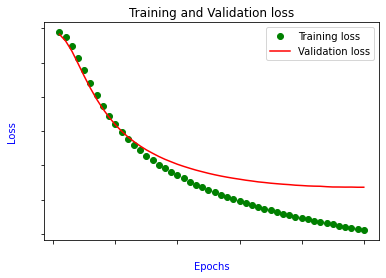

In [52]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs', color='blue')
plt.ylabel('Loss', color='blue')
plt.xticks(color='white')
plt.yticks(color='white')
plt.legend()

plt.show()

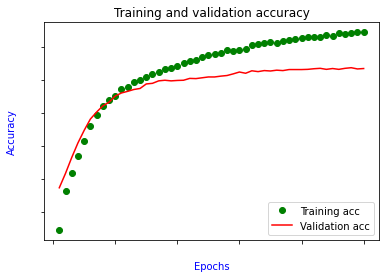

In [53]:
plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs', color='blue')
plt.ylabel('Accuracy', color='blue')
plt.xticks(color='white')
plt.yticks(color='white')
plt.legend(loc='lower right')

plt.show()

In [54]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])

loss, accuracy = export_model.evaluate(raw_test_ds)
accuracy

250/250 [==============================] - 1s 2ms/step - loss: 0.5371 - accuracy: 0.8048


0.8047500252723694

In [60]:
examples = [
    "netifaces module not found",
    ";",
    "indentation error",
    "adddlert is not defined",
    "Exception in thread 'main' java.io.FileNotFoundException: /home/project/file_path (No such file or directory)",
    "module 'tensorflow_datasets' has no attribute 'load'",
    "java",
    "html",
    "struct",
    "game"

]

export_model.predict(examples)

1/1 [==============================] - 0s 21ms/step


array([[0.48148206, 0.3936382 , 0.586661  , 0.58735347],
       [0.56144077, 0.48291948, 0.5413481 , 0.41205633],
       [0.5544282 , 0.46631178, 0.49704915, 0.4791677 ],
       [0.5164634 , 0.40477312, 0.6183862 , 0.4973743 ],
       [0.6453568 , 0.70257527, 0.15742514, 0.42048633],
       [0.4842587 , 0.36687997, 0.564769  , 0.6362463 ],
       [0.54845166, 0.38054338, 0.67535657, 0.4353516 ],
       [0.55389506, 0.43169743, 0.635882  , 0.40318787],
       [0.6303903 , 0.46230748, 0.5067591 , 0.376184  ],
       [0.5171735 , 0.5069878 , 0.5252213 , 0.45397773]], dtype=float32)

In [64]:
raw_train_ds.class_names

['csharp', 'java', 'javascript', 'python']